## MODELING  

In [1]:
#Part 2: Modeling
#A. Classification – Predicting Mental‑Health Status (Task A)
#B. Regression – Predicting Age (Task B)

In [2]:
#SUMMARY:Provide a quick overview: mention both parts—using features like workplace type, gender, openness about mental health, and remote work.
#algorithms used: Logistic Regression / Random Forest / XGBoost for classification; Linear / Random Forest / XGB for regression.
#key results and metrics (e.g. AUC for classification; RMSE, MAE, R² for regression).

## Random Forest Classifier: Preprocessing Pipeline and Model Implementation  

In [3]:
# RANDOM FOREST CLASSIFER 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing pipeline builder
def build_preprocessing_pipeline(X):
    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
        # No scaler needed for RandomForest
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def build_preprocessing_pipeline(X):
    # Identify columns
    categorical_cols = X.select_dtypes(include='object').columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Preprocessing for numeric features
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical features
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor


## CLASSIFICATION  

             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL            No   
1  2014-08-27 11:29:37   44       M   United States    IN            No   
2  2014-08-27 11:29:44   32    Male          Canada    CA            No   
3  2014-08-27 11:29:46   31    Male  United Kingdom    CA            No   
4  2014-08-27 11:30:22   31    Male   United States    TX            No   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

  mental_health_consequence phys_health_consequence     coworkers supervisor  \
0                        No                      No  Some of them       

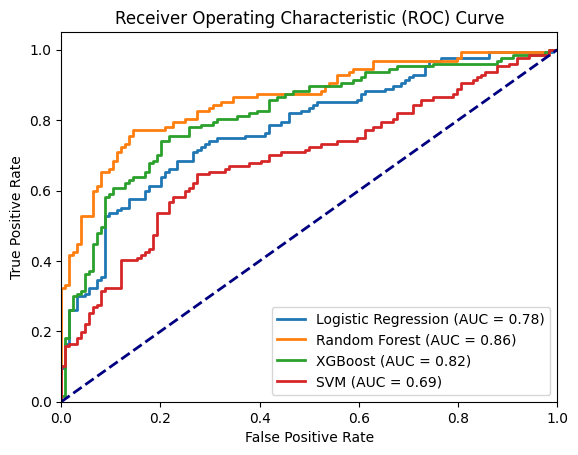

In [5]:
#a.classification part 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/kaggle/input/mental-wellness-data-eda/cleaned_mental_health.csv')
print(data.head())

# Encode categorical
cat_cols = ['Gender', 'Country', 'family_history', 'work_interfere',
            'remote_work', 'benefits', 'care_options', 'wellness_program',
            'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
            'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview',
            'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Target encoding
data['treatment'] = (data['treatment'].astype(str) == 'Yes').astype(int)

# Features and target
features = cat_cols + ['Age']
X = data[features]
y = data['treatment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    'SVM': SVC(kernel='rbf', probability=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n## {name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))
    if probas is not None:
        print("ROC-AUC:", roc_auc_score(y_test, probas))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        probas_ = model.predict_proba(X_test)[:, 1]
    else:
         probas_ = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## REGRESSION PART  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


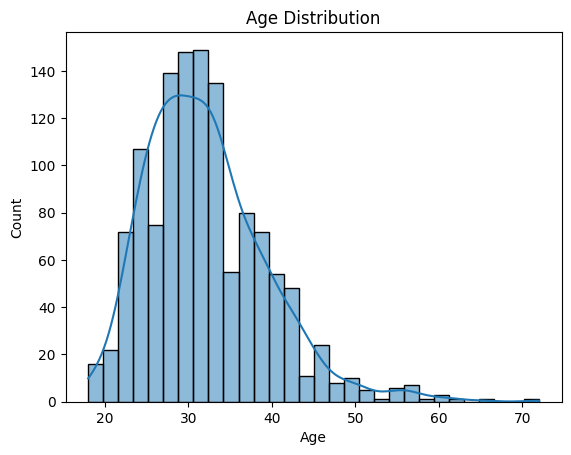

In [6]:
#linear regression part

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Xr = X.drop(columns=['Age'])
yr = data['Age']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
import seaborn as sns
sns.histplot(data['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

## LINEAR REGRESSION , RANDOM FOREST , XGBoost

In [7]:

regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBRegressor(eval_metric='rmse')
}

for name, reg in regressors.items():
    reg.fit(Xr_train, yr_train)
    preds = reg.predict(Xr_test)
    
    print(f"\n## {name}")
    print("RMSE:", np.sqrt(mean_squared_error(yr_test, preds)))
    print("MAE:", mean_absolute_error(yr_test, preds))
    print("R² score:", r2_score(yr_test, preds))


## Linear Regression
RMSE: 6.603490537493313
MAE: 5.176118331331841
R² score: 0.07659149436979373

## Random Forest
RMSE: 6.835779262466434
MAE: 5.41927315318579
R² score: 0.010484021760794104

## XGBoost
RMSE: 7.7206252276080996
MAE: 6.1693106647506655
R² score: -0.26226835322855613


##   

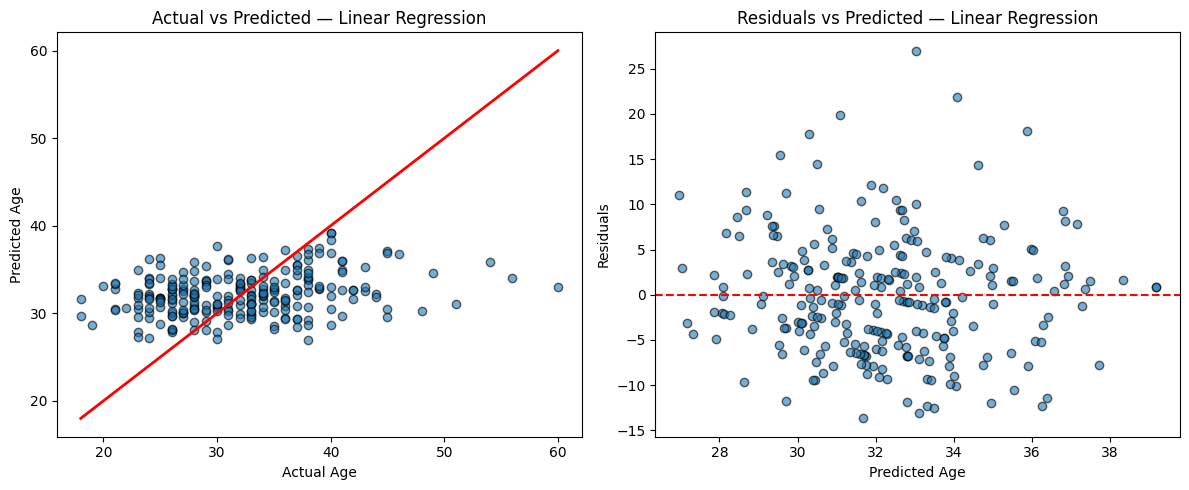

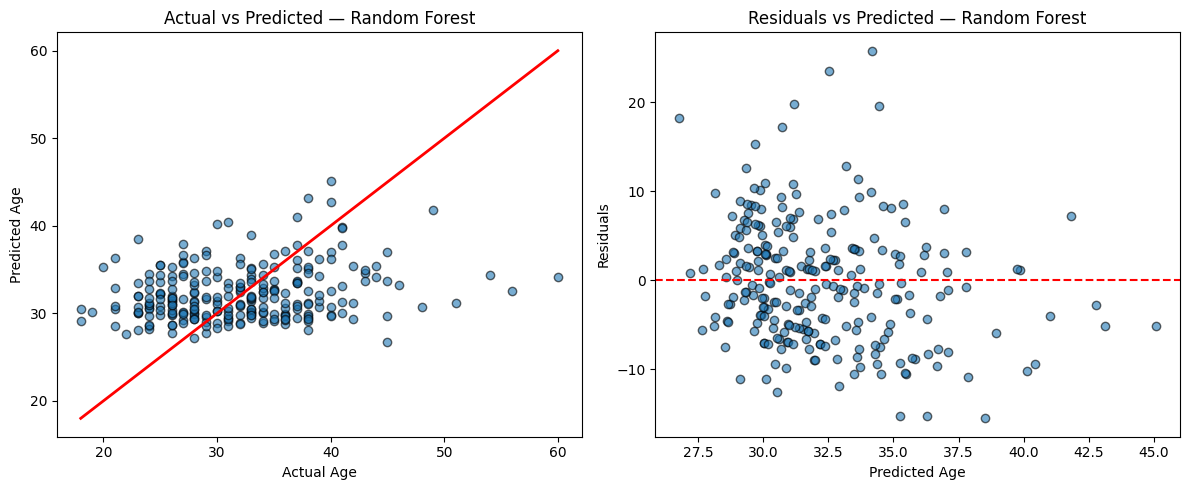

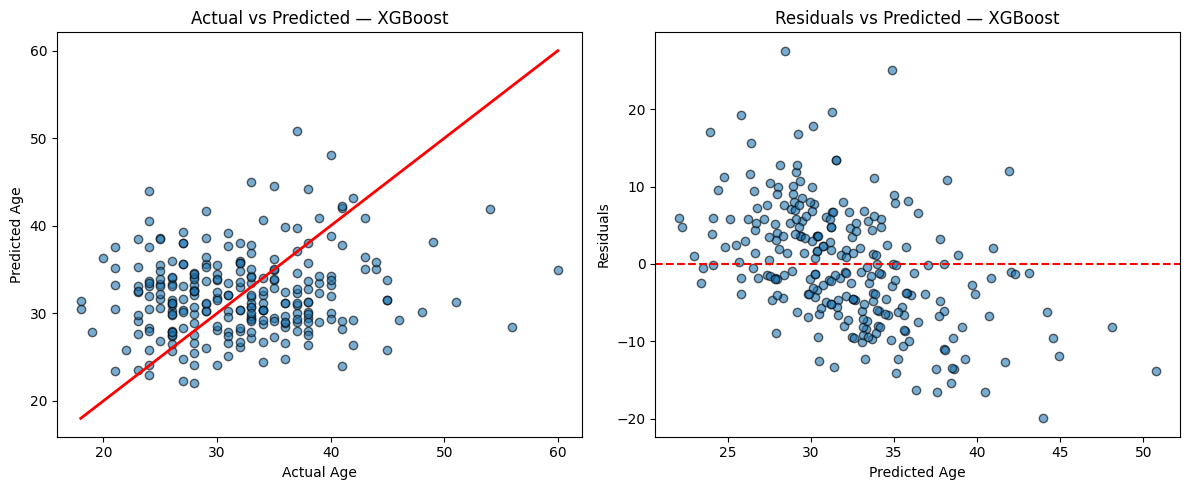

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

for name, reg in regressors.items():
    preds = reg.predict(Xr_test)
    residuals = yr_test - preds

    plt.figure(figsize=(12, 5))
    # Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(yr_test, preds, alpha=0.6, edgecolor='k')
    mn, mx = min(yr_test.min(), preds.min()), max(yr_test.max(), preds.max())
    plt.plot([mn, mx], [mn, mx], color='red', lw=2)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title(f'Actual vs Predicted — {name}')

    # Residuals vs Predicted
    plt.subplot(1, 2, 2)
    plt.scatter(preds, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Age')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted — {name}')

    plt.tight_layout()
    plt.show()

  

   
